# Setup

In [1]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lenovo/.local/lib/python3.7/site-packages/tensorflow/python

In [2]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Symmetric (secret-key) encryption


### Two-Eve Model
**Built referring zhou2019**  <br>

From the discussion in the previous models, we can see that the strength of
the encryption scheme depends largely on the ability of the adversary. Inspiring
from the fact that recovering the key or the plaintext only cannot make the
encryption protocol stronger (Alice can reduce the involvement of the key), we
introduce a two-eve adversarial model to further enhance the encryption pro-
tocol. In this new model, we have two attackers Eve1 and Eve2 with different
attacking goals. Eve1 focuses on recovering the plaintext and Eve2’s goal is to
recover the secret key. In this model, Alice cannot simply ignore the involve-
ment of the secret key due to the existence of Eve1. We further divide into the
following two categories. <br>
Key(L) + Ciphertext 
→
Plaintext(Eve1) + Key(Eve2)  <br>


In [3]:
model_name = 'crypto1'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'
eve2_file = 'models/crypto/' + model_name + '-eve2'

### Network arch

In [4]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('sigmoid')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('sigmoid')(econv3)

eoutput = Flatten()(econv3a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')
#eve.summary()

# Eve2 network
#
einput2 = Input(shape=(k_bits,)) #key only

edense12 = Dense(units=(c_bits + k_bits))(einput2)
edense1a2 = Activation('tanh')(edense12)

edense22 = Dense(units=(c_bits + k_bits))(edense1a2)
edense2a2 = Activation('tanh')(edense22)

ereshape2 = Reshape((c_bits + k_bits, 1,))(edense2a2)

econv12 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape2)
econv1a2 = Activation('tanh')(econv12)
econv22 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a2)
econv2a2 = Activation('tanh')(econv22)
econv32 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a2)
econv3a2 = Activation('tanh')(econv32)
econv42 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a2)
econv4a2 = Activation('sigmoid')(econv42)

eoutput2 = Flatten()(econv4a2)# Eve's attempt at code guessing

eve2 = Model(einput2, eoutput2, name='eve2')
eve2.summary()

Model: "eve2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_17 (Activation)   (None, 32)                0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 32, 1)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 2)             10     

In [5]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')
eve2.compile(loss='mse', optimizer='sgd')

In [6]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()
    eve2.summary()

### Loss + Optimizer

In [7]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher
eve2out = eve2( aliceout )
# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
eve2loss = K.mean(  K.sum(K.abs(ainput1 - eve2out), axis=-1)  )
# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + (K.square(m_bits/2 - eveloss)+K.square(k_bits/2- eve2loss))/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001
eveoptim2 = RMSprop(lr=0.001) #default 0.001

# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

# Build and compile the EVE2 model, used for training Eve2 net (with Alice frozen)
#
alice.trainable = False
eve2model = Model([ainput0, ainput1], eve2out, name='eve2model')
eve2model.add_loss(eve2loss)
eve2model.compile(optimizer=eveoptim2)

/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))
/home/lenovo/.local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve2.
  'be expecting any data to be passed to {0}.'.format(name))


### Train / save / restore

In [8]:
abelosses = []
boblosses = []
evelosses = []
eve2losses = []

In [9]:
abelosses = []
boblosses = []
evelosses = []
eve2losses = []
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    eve2losses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        # Train the EVE2 network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve2model.train_on_batch([m_batch, k_batch], None)
        
        eve2losses0.append(loss)
        eve2losses.append(loss)
        eve2avg = np.mean(eve2losses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | eve2: {:2.3f}| bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512

Epoch   0:  99% | abe: 7.792 | eve: 6.943 | eve2: 7.358| bob: 7.736
Epoch   1:  99% | abe: 5.662 | eve: 3.727 | eve2: 6.486| bob: 5.295
Epoch   2:  99% | abe: 3.390 | eve: 1.839 | eve2: 6.559| bob: 2.727
Epoch   3:  99% | abe: 2.120 | eve: 0.991 | eve2: 6.505| bob: 1.288
Epoch   4:  99% | abe: 1.466 | eve: 0.686 | eve2: 6.265| bob: 0.565
Epoch   5:  99% | abe: 1.203 | eve: 0.676 | eve2: 5.968| bob: 0.283
Epoch   6:  99% | abe: 1.075 | eve: 0.864 | eve2: 5.622| bob: 0.174
Epoch   7:  99% | abe: 0.992 | eve: 1.150 | eve2: 5.230| bob: 0.122
Epoch   8:  99% | abe: 0.931 | eve: 1.452 | eve2: 4.850| bob: 0.093
Epoch   9:  99% | abe: 0.890 | eve: 1.722 | eve2: 4.520| bob: 0.076
Epoch  10:  99% | abe: 0.863 | eve: 1.907 | eve2: 4.307| bob: 0.062
Epoch  11:  99% | abe: 0.842 | eve: 2.077 | eve2: 4.152| bob: 0.053
Epoch  12:  99% | abe: 0.825 | eve: 2.197 | eve2: 4.102| bob: 0.051
Epoch  13:  99% | abe: 0.812 | eve: 2.236 | eve2: 4.098| bob: 0

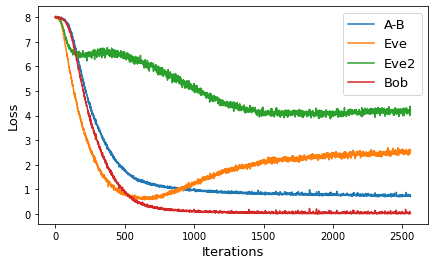

In [10]:
def plot4(abelosses,evelosses,eve2losses,boblosses):
    steps = -1
    plt.figure(figsize=(7, 4))
    plt.plot(abelosses[:steps], label='A-B')
    plt.plot(evelosses[:steps], label='Eve')
    plt.plot(eve2losses[:steps], label='Eve2')
    plt.plot(boblosses[:steps], label='Bob')
    plt.xlabel("Iterations", fontsize=13)
    plt.ylabel("Loss", fontsize=13)
    plt.legend(fontsize=13)

    #plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
    plt.show()
plot4(abelosses,evelosses,eve2losses,boblosses)

In [11]:
if False: #Don't overwrite by accident
    alice.save(alice_file + '.h5', overwrite=True)
    bob.save(bob_file + '.h5', overwrite=True)
    eve.save(eve_file + '.h5', overwrite=True)
    eve2.save(eve2_file + '.h5', overwrite=True)

In [12]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

OSError: Unable to open file (unable to open file: name = 'models/crypto/crypto1-alice.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Evaluate

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)
k_att = (eve2.predict(m_enc) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)
ediff2 = np.abs(k_batch - k_att)
esum2 = np.sum(ediff2, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')
print("Eve2 key reconstruct % correct: ", 100.0*np.sum(esum2 == 0) / n_examples, '%')

### Freeze Alice-Bob

In [ ]:
if False:
    alice = load_model(alice_file + '.h5')
    bob = load_model(bob_file + '.h5')
    eve = load_model(eve_file + '.h5')

aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher
eveout2 = eve2( aliceout )

eve2loss = K.mean(  K.sum(K.abs(ainput1 - eveout2), axis=-1)  )
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss - eve2loss)/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = Adam()#RMSprop(lr=0.001) #default 0.001
eve2optim = Adam()
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

eve2model = Model([ainput0, ainput1], eve2out, name='evemodel')
eve2model.add_loss(eve2loss)
eve2model.compile(optimizer=eve2optim)
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    eve2losses0 = []
    for iteration in range(n_batches):
        # Train Eves model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
    
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eve2loss = eve2model.train_on_batch([m_batch, k_batch], None)
        eve2losses0.append(eve2loss)
        eve2losses.append(eve2loss)
        eve2avg = np.mean(eve2losses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - eveloss - eve2loss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} |  eve2: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)
k_att = (eve2.predict(m_enc) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)
ediff2 = np.abs(k_batch - k_att)
esum2 = np.sum(ediff2, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')
print("Eve2 key reconstruct % correct: ", 100.0*np.sum(esum2 == 0) / n_examples, '%')

In [ ]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    eve2losses0 = []
    for iteration in range(n_batches):
        # Train Eves model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
    
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eve2loss = eve2model.train_on_batch([m_batch, k_batch], None)
        eve2losses0.append(eve2loss)
        eve2losses.append(eve2loss)
        eve2avg = np.mean(eve2losses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - 10*eveloss - eve2loss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} |  eve2: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
def plot4(abelosses,evelosses,eve2losses,boblosses):
    steps = -1
    plt.figure(figsize=(7, 4))
    plt.plot(abelosses[:steps], label='A-B')
    plt.plot(evelosses[:steps], label='Eve')
    plt.plot(eve2losses[:steps], label='Eve2')
    plt.plot(boblosses[:steps], label='Bob')
    plt.xlabel("Iterations", fontsize=13)
    plt.ylabel("Loss", fontsize=13)
    plt.legend(fontsize=13)

    #plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
    plt.show()
plot4(abelosses,evelosses,eve2losses,boblosses)

In [ ]:

n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)
k_att = (eve2.predict(m_enc) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)
ediff2 = np.abs(k_batch - k_att)
esum2 = np.sum(ediff2, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')
print("Eve2 key reconstruct % correct: ", 100.0*np.sum(esum2 == 0) / n_examples, '%')

### Encoding distribution

In [ ]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

Let's plot a few of the encoded vectors' coodinates:

In [ ]:
n_examples = 10000
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
m_enc = alice.predict([m_batch, k_batch])

if showAll:
    n_cols = 4
    n_rows = m_enc.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(8, int(8.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(m_enc[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=12)
            plt.hist(m_enc[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
#plt.savefig("images/" + model_name + "-encall.png", transparent=True) #dpi=100
plt.show()

In [ ]:
# Let's examine various correlations, if any
data_arr = np.c_[m_batch, k_batch, m_enc]

columns = [
    'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 
    'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 
    'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 
]

data = pd.DataFrame(data=data_arr, index=range(10000), columns=columns)
data.head()

In [ ]:
datac = data[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']]
datac.head()

In [ ]:
corr = data.corr()
corrc = datac.corr()

In [ ]:
corrc['c2'].sort_values(ascending=False)

In [ ]:
pd.plotting.scatter_matrix(datac, alpha=0.2, figsize=(12,12))
plt.show()

## Model `crypto2`

Add dense, and allow tanh for codings.

In [ ]:
K.floatx()

In [ ]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice'
bob_file = 'models/crypto/' + model_name + '-bob'
eve_file = 'models/crypto/' + model_name + '-eve'

### Network arch

In [ ]:
K.clear_session()
kersize = 4

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [ ]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [ ]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [ ]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

### Train / save / restore

In [ ]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [ ]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

#plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [ ]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

In [ ]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

# Asymmetric (public-key) encryption

## Model crypto3 (Google)

In [ ]:
# Coming soon

# AI-based encryption (POC)

Let's take model `crypto2`, for which Bob was incredibly accurate while Eve failed to decrypt the messages.

We construct a full encryption, with 32-bit float ciphertexts (vector of dim 8), so each character will encode to 32 * 8 = 256 bits

**Encryption Algorithm:**
* Convert character string to binary
* Pad the binary char encoding string wtih 3 random bits to get a block of 8 bits per character
* Pass 8-bit blocks of the string through the encryption network Bob
* The output is 8-dim vectors of type `float32`, for a total of $8 \cdot 32 = 256$ bits per character
* Convert the output to a binary string by concatenating the binary representation of each component the 8-dim float vector. **This is the encoding**

One could convert this to a character string to see what the messasge might look like. Each character will be a block of 5 (remove 3 bits for padding).

The decryption algorithm is the reverse of the above.

In [ ]:
alice = load_model('models/crypto/crypto2-alice.h5')
bob = load_model('models/crypto/crypto2-bob.h5')
eve = load_model('models/crypto/crypto2-eve.h5')

## Char map and str functions

In [ ]:
block_size_unpadded = 5
block_padding = 3
block_size = block_size_unpadded + block_padding

chrlist = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '!', '?',
    ':', ' '
]
binlist = [
    '00000', '00001', '00010', '00011', '00100', 
    '00101', '00110', '00111', '01000', '01001',
    '01010', '01011', '01100', '01101', '01110', 
    '01111', '10000', '10001', '10010', '10011',
    '10100', '10101', '10110', '10111', '11000',
    '11001', '11010', '11011', '11100', '11101', 
    '11110', '11111'
]

def randombits(n):
    if n == 0:
        return ''
    decvalue = np.random.randint(0, 2**n)
    formatstring = '0' + str(n) + 'b'
    return format(decvalue, formatstring)

def encstr(message, block_padding=0):
    cipher = ""
    for c in message:
        binstr = binlist[chrlist.index(c)]
        binstrpadded = randombits(block_padding) + str(binstr)
        cipher = cipher + binstrpadded
    return cipher, len(message)

def decstr(cipher, n, block_padding=0):
    message = ""
    cipherlength = len(cipher)
    block_size = cipherlength // n
    for i in range(n):
        blockpadded = cipher[block_size*i : block_size*i + block_size]
        blockunpadded = blockpadded[block_padding:]
        character = chrlist[binlist.index(blockunpadded)]
        message = message + character
    return message

In [ ]:
print(encstr('adi', 3))
print(decstr('00010011010001001001001001010011', 4, block_padding=3))

In [ ]:
# Function for converting float to 32-bit binary string
def float_to_binary(value):
    binNum = bin(  ctypes.c_uint.from_buffer(ctypes.c_float(value)).value  )[2:]
    binstr = binNum.rjust(32,"0")
    return binstr

def binary_to_float(binstr):
    intvalue = int(binstr, 2)
    floatvalue = ctypes.c_float.from_buffer(ctypes.c_uint(intvalue))
    return floatvalue.value

# Convert a positive integer num into a bit vector of 'bits' size
def bitarray(num, bits):
    return np.array(list(np.binary_repr(num).zfill(bits))).astype(np.int8)

In [ ]:
key = np.array([[0,0,0,0,0,0,0,0]])
m = 'adi'

m_bin, _ = encstr(m, block_padding=3)
m_bin_len = len(m_bin)
print(m_bin, m_bin_len)

ciphertext = ""
for i in range(m_bin_len // m_bits):
    # read blocks of size m_bits
    binblockstr = m_bin[m_bits*i : m_bits*i + m_bits]
    binblock = np.array(list(binblockstr)).astype(np.int8).reshape(1, m_bits)
    
    floatVector = alice.predict([binblock, key])
    #print(np.round(floatVector,3))
    
    # convert each coordinate of the cipher (float) vector to binary
    # and construct the binary ciphertext
    for j in range(c_bits):
        ciphertext = ciphertext + float_to_binary(floatVector[0][j])
        #print(float_to_binary(floatVector[0][j]))

#print(ciphertext, len(ciphertext)) # ciphertext in binary
print(decstr(ciphertext, n=(len(ciphertext)//8), block_padding=3)) #ciphertext as characters

ciphertext_len = len(ciphertext)
plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    # read the ciphertext in chunks of 32*c_bits bits, i.e one encoding at a time
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    #print(floatVectorbin)
    # convert the binary chunk to an 8-dim float vector (input for AI Bob)
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        #print(floatValuebin)
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    #print(np.round(floatVector,3))
    
    charbinvector = list( (bob.predict([floatVector, key]) > 0.5)[0].astype(int) )
    for j in range(len(charbinvector)):
        plaintextbin = plaintextbin + str(charbinvector[j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

In [ ]:
# How would Eve peform on the above ciphertext?

plaintextbin = ""
for i in range(ciphertext_len // (c_bits*32)):
    floatVectorbin = ciphertext[c_bits*32*i : c_bits*32*i + c_bits*32]
    floatVector = np.zeros(c_bits, dtype=np.float32).reshape(1, c_bits)
    for j in range(len(floatVectorbin) // 32):
        floatValuebin = floatVectorbin[32*j : 32*j + 32]
        floatValue = binary_to_float(floatValuebin)
        floatVector[0][j] = floatValue
    charbinvector = (eve.predict(floatVector) > 0.5).astype(int)
    for j in range(charbinvector.shape[1]):
        plaintextbin = plaintextbin + str(charbinvector[0][j])

print(plaintextbin)

m_dec = ""
for i in range(len(plaintextbin) // m_bits):
    strbin = plaintextbin[m_bits*i : m_bits*i + m_bits]
    m_dec = m_dec + decstr(strbin, len(strbin)//m_bits, block_padding=3)

print(m_dec)

# End